## This version does the ZOGY but computes the kernels in fourier space, and then convolves images in real space.

Do it with new testing object.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

Use the code from `diffimTests.py`.

In [2]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., varSourceChange=1500., 
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)

Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0, 0]
PSF y spatial-variation: 0.0 0.0
Variable source: 37 245.899250131 279.361590046 1423.89964966 2923.89964966
(0.058941207521673616, 17.142582277831181, -74.0, 1741.5550996425638)
(0.16735074378053241, 17.213851327082029, -82.0, 1169.0572762553779)
(300.05894120752163, 17.142582277831185, 226.0, 2041.5550996425638)
(300.16735074378062, 17.213851327082025, 218.0, 1469.0572762553779)


In [3]:
reload(dit)
testObj.doAL(spatialKernelOrder=0, spatialBackgroundOrder=1)
print dit.computeClippedImageStats(testObj.D_AL.im)
testObj.doZOGY()
print dit.computeClippedImageStats(testObj.D_ZOGY.im)

(-0.0031786170914947362, 0.98196168826087515, -4.7257007356951117, 5.7559089878418082)
(-0.00091946279216619279, 0.98658699240597725, -4.8672571236886055, 4.4549309460273108)


/home/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


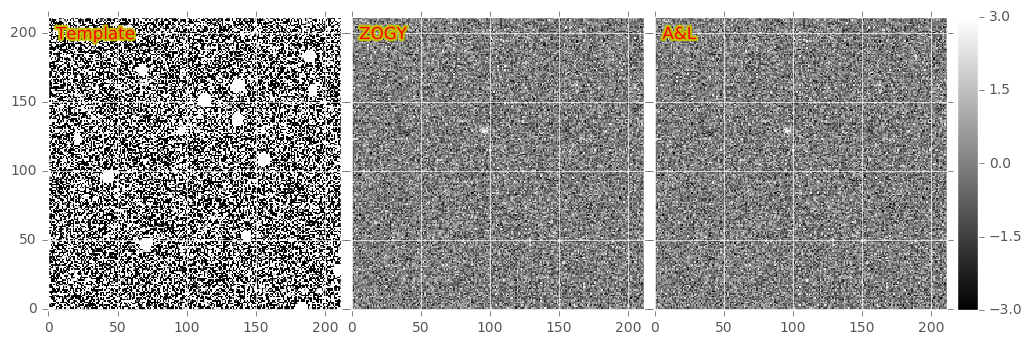

In [4]:
xim = np.arange(-256, 256, 1)
yim = xim.copy()

fig = plt.figure(1, (12, 12))
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
extent = (xim.min()+150, xim.max()-150, yim.min()+150, yim.max()-150)
dit.plotImageGrid((testObj.im1.im[x1d:x2d,y1d:y2d], 
                   testObj.D_ZOGY.im[x1d:x2d,y1d:y2d], 
                   testObj.D_AL.im[x1d:x2d,y1d:y2d]), 
                  clim=(-3,3), titles=['Template', 'ZOGY', 'A&L'])

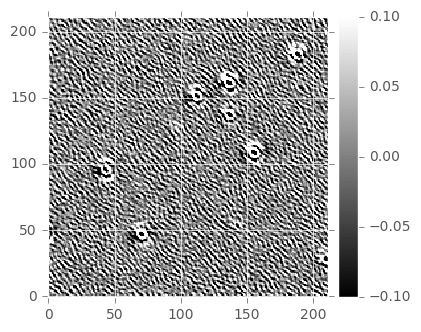

In [5]:
D = testObj.D_ZOGY.im.copy()
D_AL = testObj.D_AL.im.copy()

D[0,:] = D[:,0] = D[-1,:] = D[:,-1] = 0.
D_AL[D == 0] = 0.
fig = plt.figure(1, (4, 4))
dit.plotImageGrid(((D - D_AL)[x1d:x2d,y1d:y2d],), clim=(-0.1, 0.1))

Work on variance planes.

(0.010771440925175148, 0.97869443986664717, -4.527872818281959, 9.1269917837064956)
(6.8054576238311403e-05, 0.0060991321441819825, -0.028160865936554463, 0.062271139296035449)
[ 245.89925013  279.36159005] 9.12699178371
29


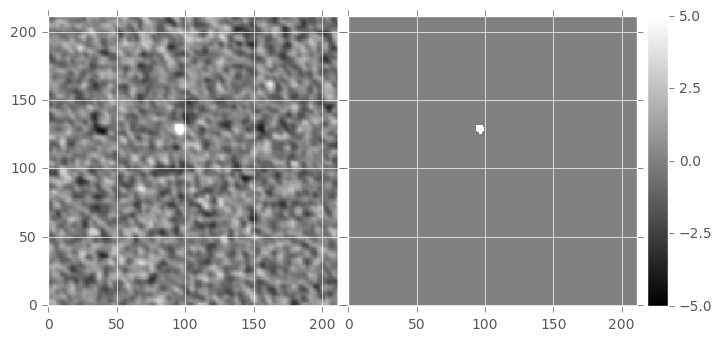

In [6]:
reload(dit);

S_corr, S = testObj.S_corr_ZOGY.im, testObj.S_ZOGY.im
print dit.computeClippedImageStats(S_corr)
print dit.computeClippedImageStats(S)
changedCentroid = testObj.centroids[testObj.changedCentroidInd, :]
print changedCentroid, S_corr[np.rint(changedCentroid[1]).astype(int), np.rint(changedCentroid[0]).astype(int)]
print (S_corr > 5.).sum() + (S_corr < -5.).sum()
fig = plt.figure(1, (8, 8))
dit.plotImageGrid((S_corr[x1d:x2d,y1d:y2d], ((S_corr > 5.)*5.0 + (S_corr < -5.)*-5.0)[x1d:x2d,y1d:y2d]), 
                  clim=(-5.,5.))

### Try the reverse case where science is narrower than template...

For A&L, turn on pre-filtering.

In [7]:
reload(dit)
testObj2 = testObj.clone()
testObj2.reverseImages()

testObj2.doZOGY()
dstats_ZOGY = dit.computeClippedImageStats(testObj2.D_ZOGY.im)
print dstats_ZOGY
testObj2.doAL(spatialKernelOrder=0, spatialBackgroundOrder=1, doPreConv=False)
print dit.computeClippedImageStats(testObj2.D_AL.im)
D_AL = testObj2.D_AL  # save the non-preconv-ed version
D_kappa = testObj2.kappa_AL
testObj2.doAL(spatialKernelOrder=0, spatialBackgroundOrder=1, doDecorr=False, doPreConv=True)
print dit.computeClippedImageStats(testObj2.D_AL.im)
D_AL_noDecorr = testObj2.D_AL  # save the non-preconv-ed version
D_kappa_noDecorr = testObj2.kappa_AL
testObj2.doAL(spatialKernelOrder=0, spatialBackgroundOrder=1, doPreConv=True)
print dit.computeClippedImageStats(testObj2.D_AL.im)

(0.00091946279216619279, 0.98658699240597725, -4.4549309460273108, 4.8672571236886055)
(-0.0037926939293825711, 0.96502411596507087, -6.7190792205938745, 19.21647917936917)
(-0.0028241355746972453, 0.76808277792729684, -7.357539171061938, 19.582235722722945)
(-0.00064114352937952898, 0.16517725516302401, -1.4833510608308476, 2.5034359557741648)


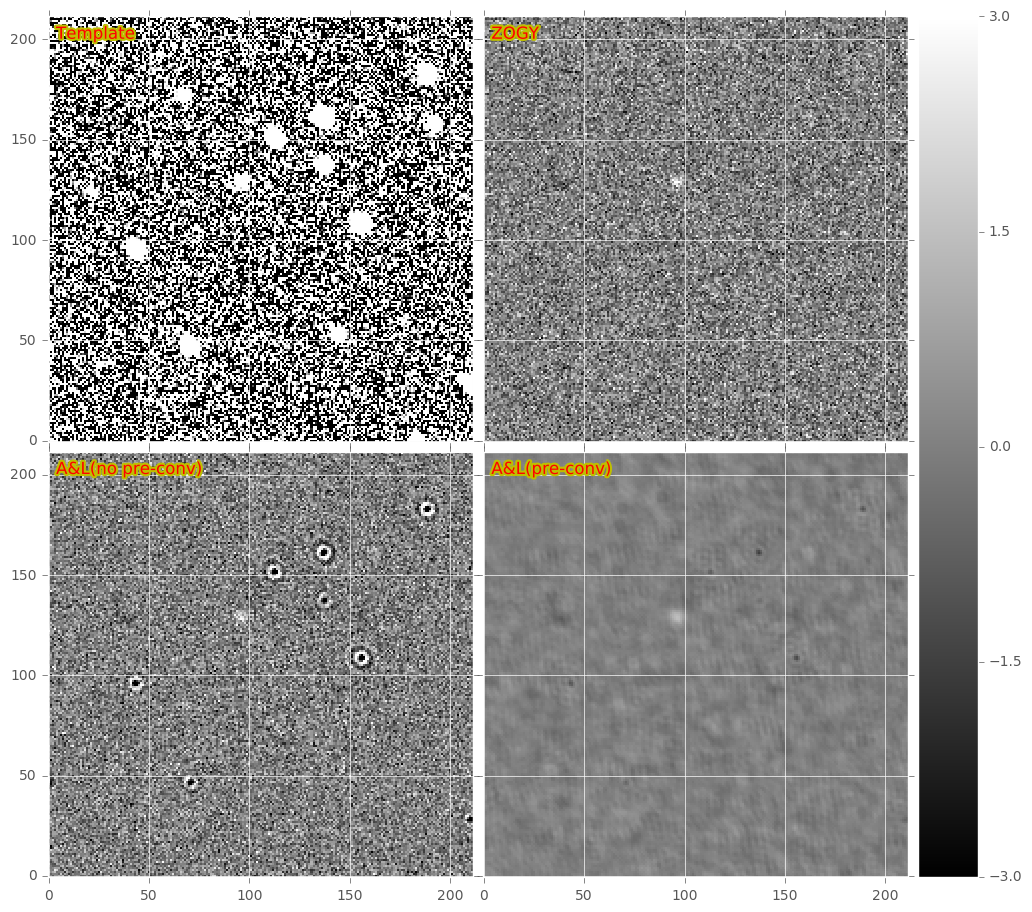

In [8]:
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((testObj2.im1.im[x1d:x2d,y1d:y2d], -testObj2.D_ZOGY.im[x1d:x2d,y1d:y2d], 
                   -D_AL.im[x1d:x2d,y1d:y2d], -testObj2.D_AL.im[x1d:x2d,y1d:y2d]), 
                  clim=(-3,3), titles=['Template', 'ZOGY', 'A&L(no pre-conv)', 'A&L(pre-conv)'])

(-0.00064114352937952898, 0.16517725516302401, -1.4833510608308476, 2.5034359557741648)
(0.011459321226940692, 0.46720495540102963, -3.5024855923826417, 14.638825678758703)
122


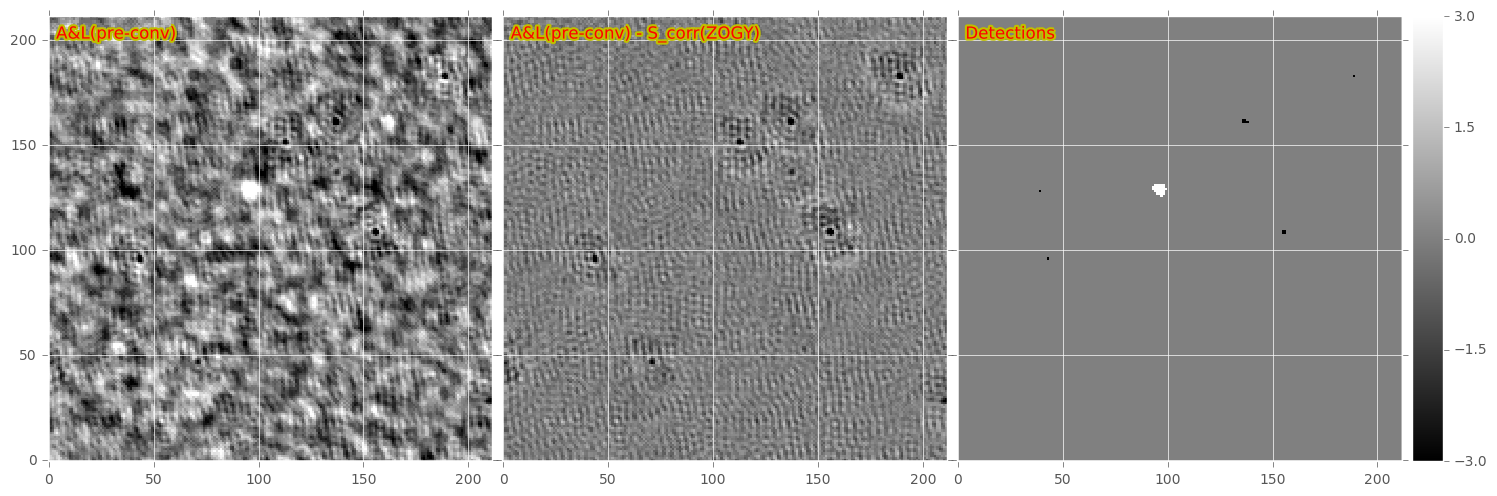

In [9]:
dstats = dit.computeClippedImageStats(testObj2.D_AL.im)
print dstats
#D_AL_pc_ALZC /= 3.0
tmp = (testObj2.D_AL.im - dstats[0]) / dstats[1]
print dit.computeClippedImageStats(tmp-testObj2.S_corr_ZOGY.im)
print (tmp > 5.).sum() + (tmp < -5.).sum()
fig = plt.figure(1, (18, 18))
dit.plotImageGrid((-tmp[x1d:x2d,y1d:y2d], -(tmp-testObj2.S_corr_ZOGY.im)[x1d:x2d,y1d:y2d], 
                   ((tmp > 5.)*-5. + (tmp < -5.)*5.)[x1d:x2d,y1d:y2d]), clim=(-3., 3.),
                 titles=['A&L(pre-conv)', 'A&L(pre-conv) - S_corr(ZOGY)', 'Detections'])

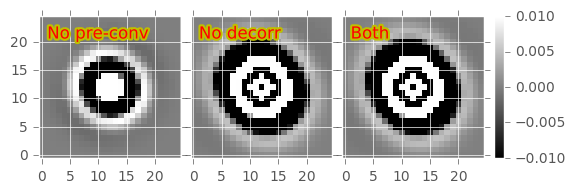

In [10]:
dit.plotImageGrid((D_kappa, D_kappa_noDecorr, testObj2.kappa_AL), titles=['No pre-conv', 'No decorr', 'Both'], 
                  clim=(-0.01,0.01))

In [11]:
%timeit testObj.doZOGY()

1 loop, best of 3: 804 ms per loop


In [12]:
%timeit testObj.doAL(spatialKernelOrder=0, spatialBackgroundOrder=1, kernelSize=15)

1 loop, best of 3: 14.5 s per loop


## Do it in the stack!

Reverse the template and science image. Pre-convolution and decorrelation? Need to implement them myself since right now they are part of pipe_tasks, not ip_diffim.

Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0, 0]
PSF y spatial-variation: 0.0 0.0
Variable source: 37 245.899250131 279.361590046 1423.89964966 2923.89964966


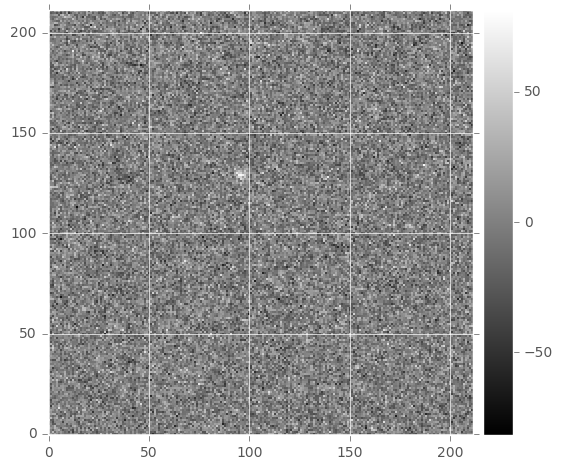

In [13]:
reload(dit)

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., varSourceChange=1500., 
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)
result = testObj.doALInStack()
fig = plt.figure(1, (6, 6))
dit.plotImageGrid((result.subtractedExposure.getMaskedImage().getImage().getArray()[x1d:x2d,y1d:y2d],))

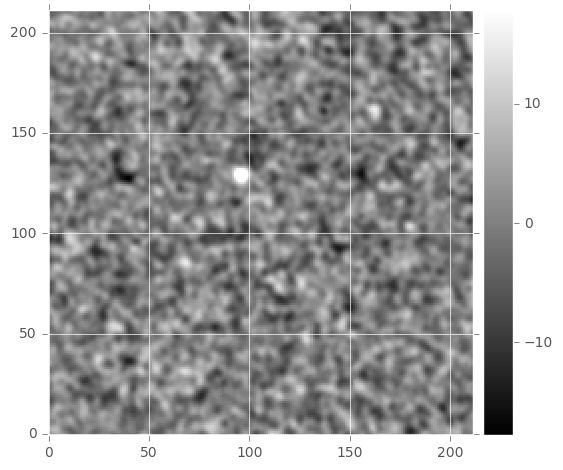

In [14]:
testObj2 = testObj.clone()
testObj2.reverseImages()
result = testObj2.doALInStack(doPreConv=True, doDecorr=False)

fig = plt.figure(1, (6, 6))
dit.plotImageGrid((-result.subtractedExposure.getMaskedImage().getImage().getArray()[x1d:x2d,y1d:y2d],))

In [15]:
reload(dit)

testObj2 = testObj.clone()
testObj2.reverseImages()
result = testObj2.doALInStack(doPreConv=True, doDecorr=True)

(21, 21) (21, 21)


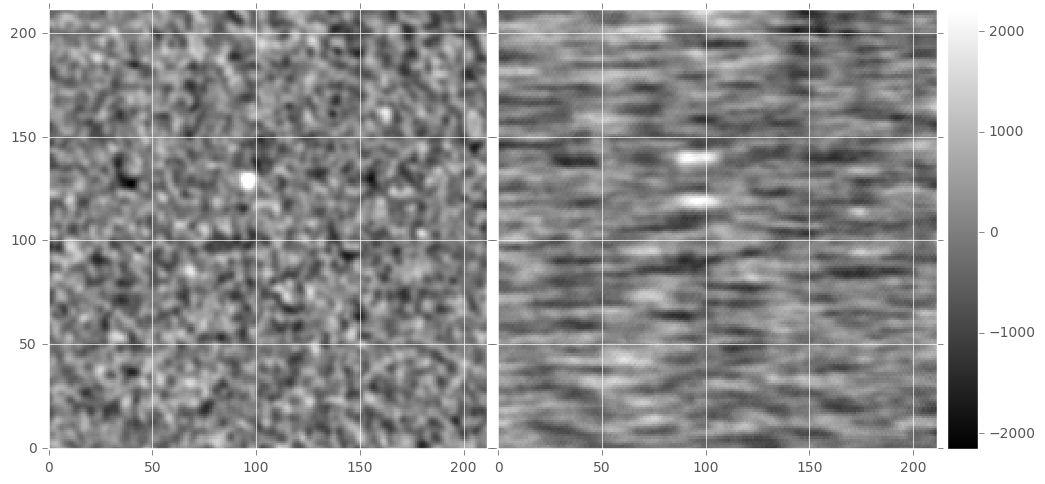

In [16]:
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((-result.subtractedExposure.getMaskedImage().getImage().getArray()[x1d:x2d,y1d:y2d],
                   -result.decorrelatedDiffim.getMaskedImage().getImage().getArray()[x1d:x2d,y1d:y2d]))

In [18]:
%timeit result = testObj2.doALInStack(doPreConv=False)

1 loop, best of 3: 3.05 s per loop


In [19]:
%timeit result = testObj2.doALInStack(doPreConv=True)

1 loop, best of 3: 3.3 s per loop


In [20]:
%timeit result = testObj2.doZOGY()

1 loop, best of 3: 801 ms per loop
